In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data = pd.read_csv('./sw_classifications_20160527.csv')

In [3]:
data.head()

,swi_id,swj_id,swi_geom,swj_geom,connected,username,timestamp
0,309963,317735,010200000002000000FB3CEA9DC7935EC08902972360CC...,010200000002000000699C891DF0935EC060CB94877CCC...,f,Sumit,2016-05-24 02:29:15.820404+00
1,313312,313373,010200000002000000A2BCE99980925EC0D7DE25935DCC...,010200000002000000182B66EE92925EC00F6FA3F743CC...,t,Annie T,2016-05-26 03:27:50.283528+00
2,304826,305160,010200000002000000E39CA78061935EC0A92043F180D6...,010200000002000000CB14431650935EC00E56906ABAD6...,f,Annie T,2016-05-26 03:44:58.635554+00
3,306273,306938,010200000002000000C9C226BCB5955EC0568370BE61D8...,01020000000200000043E1C5F69E955EC058E9BFB429D8...,f,Anonymous,2016-05-26 04:24:03.041748+00
4,306373,306697,0102000000020000006F1D84D861925EC065187A35F8D6...,01020000000200000027997E7153925EC0A637A03531D7...,f,sophia,2016-05-26 05:12:59.299378+00


We want to only consider sidewalk pairs that have at least 3 labels.

In [5]:
gb = data.groupby(['swi_id', 'swj_id'])
groups = gb.groups
more_3 = {key: value for key, value in groups.iteritems() if len(value) >= 3}
more_2 = {key: value for key, value in groups.iteritems() if len(value) >= 2}
print 'Number of unique sidewalk pair labels: {}'.format(len(groups))
print 'Number of labels with 3 or more responses: {}'.format(len(more_3))
print 'Number of labels with 2 or more responses: {}'.format(len(more_2))

Number of unique sidewalk pair labels: 11132
Number of labels with 3 or more responses: 1947
Number of labels with 2 or more responses: 1971


The groups are a dictionary of group element + index. To get to the actual labels, we can just grab the row at that index from our data frame.

In [6]:
more_2.items()[:3]

[((325902, 326474), [6366, 13072, 15004]),
 ((295084, 298785), [9498, 12565, 12655]),
 ((326184, 326185), [826, 11387, 11430])]

In [7]:
def label_fraction(sw_labelset):
    '''
    :param sw_labelset: List of 't' (True) or 'f' (False) labels for a single sidewalk pair.
    :type sw_labelset: list
    
    '''
    tf = data.iloc[sw_labelset, :]['connected']
    fraction_t = sum([1 for label in tf if label == 't']) / float(len(sw_labelset))
    
    return fraction_t

def decide_label(fraction):
    '''Decide how to label a given sidewalk pair given multiple responses.'''
    # If majority is 't', choose 't'
    if fraction > 0.5:
        return 't'
    # If majority is 'f', choose 'f'
    elif fraction < 0.5:
        return 'f'
    # If even split, ignore entirely for now
    else:
        return None

In [9]:
fractions2 = []
labels2 = []
for key, value in more_2.iteritems():
    fraction = label_fraction(value)
    label = decide_label(fraction)
    if label is not None:
        newrow = data.ix[value[0],['swi_id', 'swj_id', 'connected']]
        newrow['connected'] = label
        labels2.append(newrow)
        fractions2.append(fraction)

labels2 = pd.DataFrame(labels2)
labels2.head()

,swi_id,swj_id,connected
6366,325902,326474,f
9498,295084,298785,t
826,326184,326185,f
2638,297773,303110,f
2015,322238,330093,f


In [11]:
fractions3 = []
labels3 = []
for key, value in more_3.iteritems():
    fraction = label_fraction(value)
    label = decide_label(fraction)
    if label is not None:
        newrow = data.ix[value[0],['swi_id', 'swj_id', 'connected']]
        newrow['connected'] = label
        labels3.append(newrow)
        fractions3.append(fraction)

labels3 = pd.DataFrame(labels3)
labels3.head()

,swi_id,swj_id,connected
6366,325902,326474,f
9498,295084,298785,t
826,326184,326185,f
2638,297773,303110,f
2015,322238,330093,f


In [12]:
labels2['connected'].describe()

count     1969
unique       2
top          f
freq      1533
Name: connected, dtype: object

In [13]:
labels3['connected'].describe()

count     1946
unique       2
top          f
freq      1514
Name: connected, dtype: object

(array([ 1463.,     0.,     0.,    51.,     0.,     0.,    46.,     0.,
            0.,   386.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

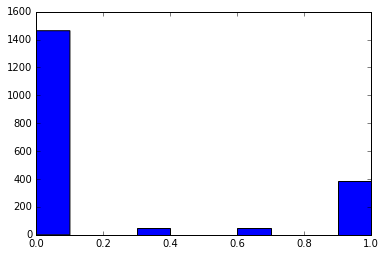

In [14]:
plt.hist(fractions3)

In [15]:
uncontested = [f for f in fractions3 if f != 0 and f != 1]
len(uncontested) / float(len(fractions3))

0.04984583761562179

'labels2' contains all majority-rule labels that have 2 or more responses. 'labels3' contains all majority-rule labels that have 3 or more responses.

### Gini coefficient

We want to use the Gini coefficient to measure the distribution of user responses - i.e., do we have a few power users providing all the data, or evenly-distributed, or something in between? The Gini coefficient will give a near-0 value for equally-distributed work and a near-1 value for putting allt he work on just 1 user out of many.

The Gini coefficient was historically used on an income distribution over a population (it's an economics thing). It therefore expects 1-dimensional data. In our case, that 1-D data will be total number of submissions per user.

In [18]:
user_counts = data.groupby(['username']).count()['connected']
user_counts.head()

username
Annie T        258
Anonymous      266
Blue            11
Ladan          604
Lissi Sevao     21
Name: connected, dtype: int64

In [46]:
def gini_estimate(value_list):
    '''Calculates the Gini coefficient for a 1D numerical dataset. 
    Rather than using continuous Lorenz curve, uses linear interpolation with
    sorted discrete values.'''
    
    values = sorted(value_list)
    n = len(values)
    cum_height = 0
    cum_area = 0
    
    for value in values:
        cum_area += cum_height + (value - cum_height) / 2
        cum_height += value
        
    line_equality_area = cum_height * n / 2.
    
    print cum_area
    print line_equality_area
    
    return (line_equality_area - cum_area) / line_equality_area

In [47]:
gini_estimate(user_counts)

40031
218486.0


0.81678002251860526